In [ ]:
!pip install plotly
!pip install openpyxl

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

In [ ]:
# Configure plotly for notebook rendering
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [ ]:
df_labels = pd.read_excel('../data/raw/AirQuality_Krakow/2019_PM10_1g.xlsx')
df_labels.head()

In [ ]:
df_processed = pd.read_csv('../data/processed/weather_basic_preprocessing.csv')
df_processed.head()

In [ ]:
df_processed['REPORT_TYPE'].value_counts()

In [ ]:
df_processed.groupby('DATE')['REPORT_TYPE'].nunique()

Jasne – to wygląda na dane pogodowe z raportów lotniczych (METAR/TAF) albo jakiegoś systemu pomiarowego. Rozpiszę Ci kolumny:

DATE – data i godzina pomiaru/raportu (timestamp).

REPORT_TYPE – typ raportu (np. METAR, SPECI, SYNOP, itp.).

GA1, GA2, MA1, MD1, MW1 – skróty specyficzne dla źródła danych. Zwykle oznaczają grupy pomiarowe lub kody z raportu METAR:

GA1, GA2 – mogą dotyczyć warstw zachmurzenia (cloud amount).

MA1, MD1, MW1 – często oznaczają pogodę towarzyszącą (np. mgła, deszcz, wiatr, mgła dymna). Tu trzeba by zajrzeć do dokumentacji datasetu.

wind_speed_raw – prędkość wiatru (surowa wartość, pewnie w węzłach lub m/s).

wind_dir_sin – sinus kąta kierunku wiatru (przekształcone do ML, żeby uniknąć problemu 0° ≈ 360°).

wind_dir_cos – cosinus kąta kierunku wiatru (to samo jak wyżej).

ceiling_height_ft – wysokość najniższej warstwy chmur (tzw. ceiling) w stopach.

ceiling_coverage – pokrycie nieba przez tę warstwę (np. SCT, BKN, OVC → przekształcone na wartości).

visibility_m – widzialność w metrach.

temperature_C – temperatura powietrza w °C.

SLP_hpa – Sea Level Pressure, ciśnienie zredukowane do poziomu morza, w hPa.

DEW_C – temperatura punktu rosy w °C.

In [ ]:
stations = df_labels.columns[1:].to_list()

In [ ]:
df_processed['DATE'] = pd.to_datetime(df_processed['DATE'])
df_labels['DateTime'] = pd.to_datetime(df_labels['DateTime'])


In [ ]:
import plotly.graph_objects as go

stations = df_labels.columns[1:].to_list()
features = [
    'wind_speed_raw', 
    'wind_dir_sin',
    'wind_dir_cos',
    'ceiling_height_ft',
    'ceiling_coverage',
    'visibility_m',
    'temperature_C',
    'SLP_hpa',
    'DEW_C'
]

fig = go.Figure()

for i, station in enumerate(stations):
    fig.add_trace(
        go.Scatter(
            x=df_labels['DateTime'],
            y=df_labels[station],
            mode='lines',
            name=station,
            visible=(i == 0) 
        )
    )

for feat in features:
    fig.add_trace(
        go.Scatter(
            x=[], 
            y=[],
            mode='lines',
            name=f"Feature: {feat}",
            visible=True
        )
    )

buttons = []

for i, station in enumerate(stations):
    mask = df_processed['DATE'].between(df_labels['DateTime'].min(), df_labels['DateTime'].max())
    
    visible = [False] * (len(stations) + len(features))
    visible[i] = True  

    for j, feat in enumerate(features):
        visible[len(stations) + j] = True

    args = {"visible": visible, "title": f"Stacja: {station}"}

    update_feature_data = []
    for j, feat in enumerate(features):
        mask = (df_processed['DATE'] >= df_labels['DateTime'].min()) & \
               (df_processed['DATE'] <= df_labels['DateTime'].max())
        x_data = df_processed.loc[mask, 'DATE']
        y_data = df_processed.loc[mask, feat]
        update_feature_data.append(dict(x=x_data, y=y_data))

    args["x"] = [df_labels['DateTime'] if k < len(stations) else update_feature_data[k - len(stations)]["x"] 
                 for k in range(len(stations) + len(features))]
    args["y"] = [df_labels[station] if k == i else [] if k < len(stations) else update_feature_data[k - len(stations)]["y"] 
                 for k in range(len(stations) + len(features))]

    buttons.append(
        dict(
            label=station,
            method="update",
            args=[args]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.05,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ],
    title=f"Stacja: {stations[0]}",
    xaxis=dict(title="Czas"),
    yaxis=dict(title="Wartość"),
    width=1800,
    height=600
)

mask = (df_processed['DATE'] >= df_labels['DateTime'].min()) & (df_processed['DATE'] <= df_labels['DateTime'].max())
for j, feat in enumerate(features):
    fig.data[len(stations) + j].x = df_processed.loc[mask, 'DATE']
    fig.data[len(stations) + j].y = df_processed.loc[mask, feat]

fig.show()


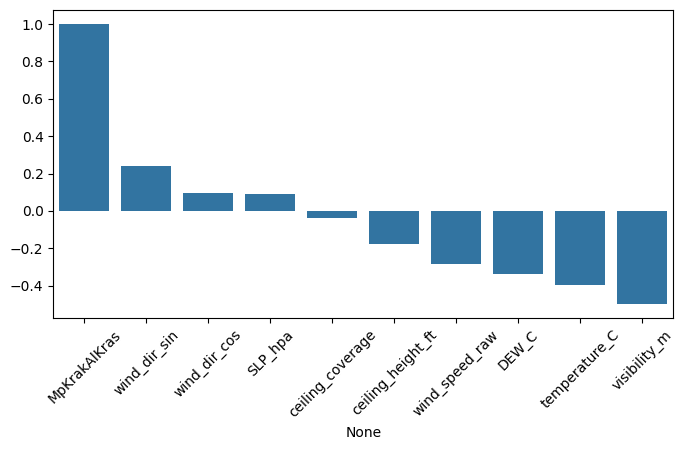

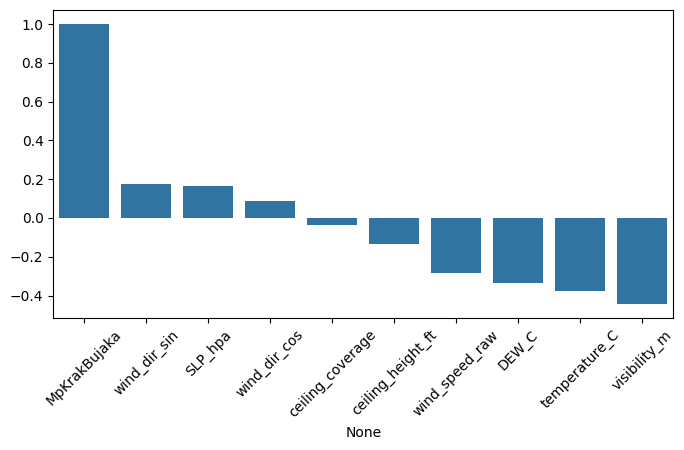

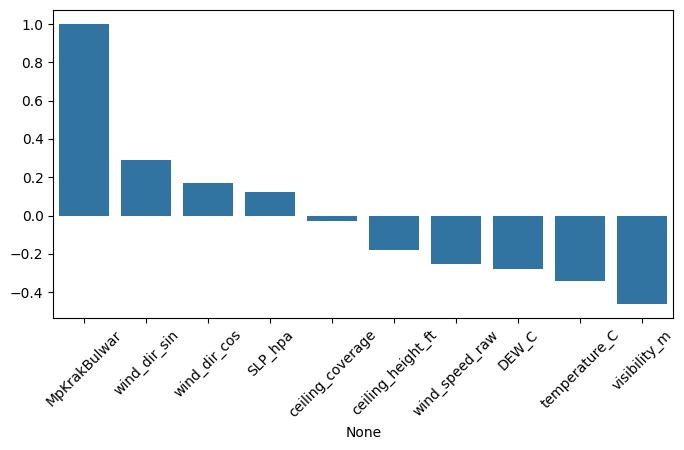

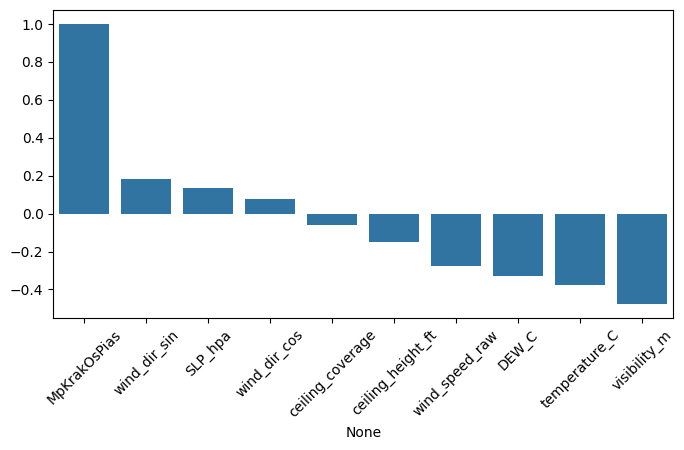

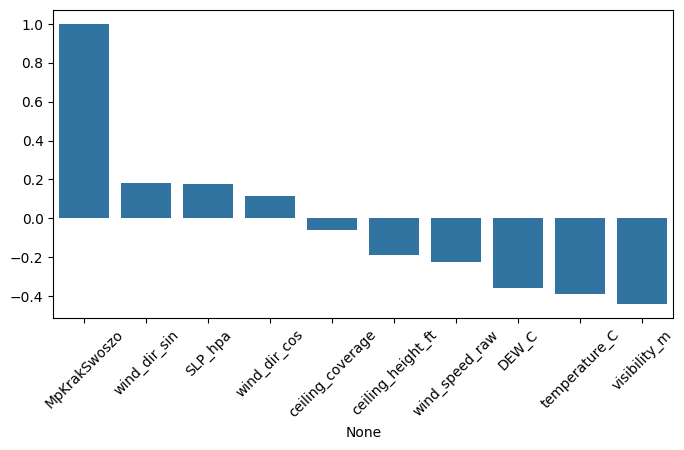

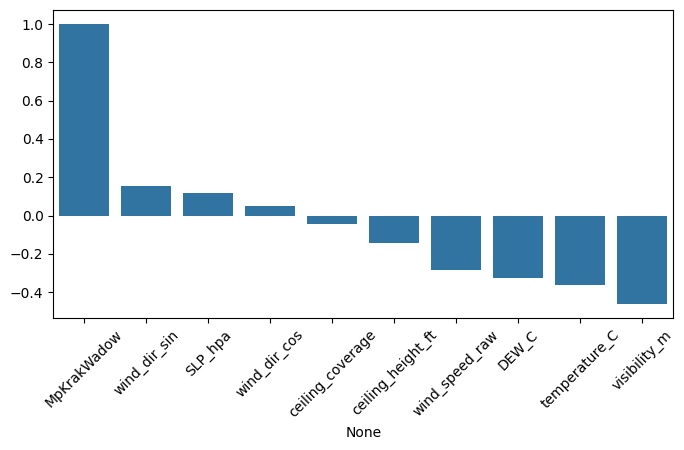

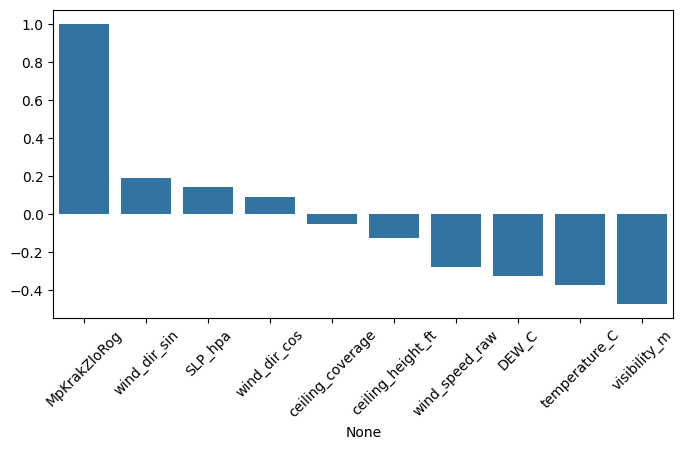

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = [
    'wind_speed_raw', 
    'wind_dir_sin',
    'wind_dir_cos',
    'ceiling_height_ft',
    'ceiling_coverage',
    'visibility_m',
    'temperature_C',
    'SLP_hpa',
    'DEW_C'
]

stations = df_labels.columns[1:]

df_merged = pd.merge(df_labels, df_processed, left_on='DateTime', right_on='DATE', how='inner')

for station in stations:
    corr = df_merged[features + [station]].corr()[station].sort_values(ascending=False)
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=corr.index, y=corr.values)
    plt.xticks(rotation=45)
    plt.show()


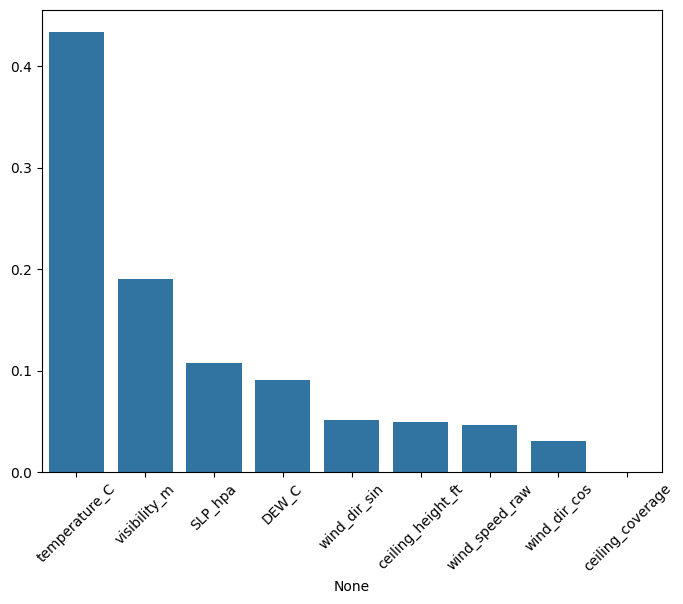

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df_long = pd.melt(
    df_labels,
    id_vars=['DateTime'],
    value_vars=stations,
    var_name='station',
    value_name='pollution'
)

df_long = pd.merge(df_long, df_processed, left_on='DateTime', right_on='DATE', how='left')
df_long = df_long.dropna(subset=features + ['pollution'])

X = df_long[features]
y = df_long['pollution']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)


plt.figure(figsize=(8,6))
sns.barplot(x=importances.index, y=importances.values)
plt.xticks(rotation=45)
plt.show()
